You are going to forecast both univariate and multivariate time series data.

In [0]:
!pip uninstall -y tensorflow
!pip install -q tf-nightly

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

print("Tensorflow Version: {}".format(tf.__version__))
print("GPU {} available.".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.2.0-dev20200324
GPU is available.


# The weather dataset

This tutorial uses a [weather time series dataset](https://www.bgc-jena.mpg.de/wetter/) recorded by the [Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/).

This datasets contain 14 different features, such as air temperature, atmospheric pressure, and humidity. These datasets were collected every 10 minutes. Here we used the dataset prepared by rançois Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [2]:
zip_path = tf.keras.utils.get_file(
  fname="jena_climate_2009_2016.csv.zip",
  origin="https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip", 
  extract=True
)
print(zip_path)

csv_path, _ = os.path.splitext(zip_path)
print(csv_path)

13574144/13568290 [==============================] - 0s 0us/step
/root/.keras/datasets/jena_climate_2009_2016.csv.zip
/root/.keras/datasets/jena_climate_2009_2016.csv


In [0]:
df = pd.read_csv(filepath_or_buffer=csv_path)

In [4]:
df.head(10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


Here you can split the data into the training for the first 300,000 rows and the validation for the remaining datasets. 

In [5]:
len(df.index)

420551

In [0]:
TRAIN_SPLIT = 300000

Set the random seed for reproducibility.

In [0]:
tf.random.set_seed(10)

As you can see, an observation is recorded every 10 minutes. That means, 6 observations were recorded in a hour, and 144 (=6x24) ones in a day.

Given a specific time, for a prediction scenario you want to predict the temperature for the next 6 hours in the future. To make such a prediction, you choose to use 5 days of observations. That says, you would create a window using the last 720 observations (=5x144) to train a model for predicting the observations in next 6 hours (=6x6). Many such configurations are possibile to work so make this dataset a good one to experiment with.

Next, you are going to prepare the data pipeline. You implement the above architecture. The parameter `history_size` is the size of the past window of information. The `parameter `target_size` is how far in the future does the model need to learn for prediction. That is to say, the `target_size` is the label that needs to be predicted.

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  label = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for idx in range(start_index, end_index):
    train_idx = range(idx - history_size, idx)
    # reshape the data from (hsitory_size,) to (history_size, 1)
    data.append(np.reshape(dataset[train_idx], newshape=(history_size, 1)))
    label.append(dataset[idx + target_size])
  
  return np.array(data), np.array(label)

# Forecast a univariate time series

First, you will train a model using only a single feature (temperature), and use it to make a prediction for that value in the future.

In [9]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [10]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head(n=10)

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
01.01.2009 01:00:00   -8.05
01.01.2009 01:10:00   -7.62
01.01.2009 01:20:00   -7.62
01.01.2009 01:30:00   -7.91
01.01.2009 01:40:00   -8.43
Name: T (degC), dtype: float64

Let's observe how this data looks across time.

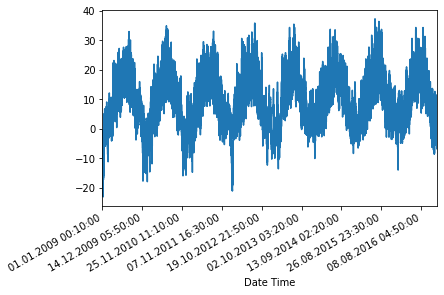

In [11]:
uni_data.plot(subplots=True)
plt.show()

In [0]:
# from pd.series to np.array
uni_data = uni_data.values

Normalize the continuous data.

In [13]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

print("Training Data Mean {}, Std {}".format(uni_train_mean, uni_train_std))

Training Data Mean 9.233256299999999, Std 8.636720398054864


In [0]:
uni_data = (uni_data - uni_train_mean) / uni_train_std

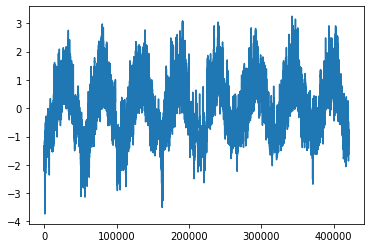

In [15]:
plt.plot(uni_data)
plt.show()

Let's now create the data for the univariate model. The model would use the last 20 recorded temperature observations, and need to learn for predicting the temperature at the next step.

In [0]:
univariate_history_size = 20
univariate_target_size = 0

x_train_uni, y_train_uni = univariate_data(
  uni_data, start_index=0, end_index=TRAIN_SPLIT, 
  history_size=univariate_history_size,
  target_size=univariate_target_size)

x_val_uni, y_val_uni = univariate_data(
  uni_data, start_index=TRAIN_SPLIT, end_index=None,
  history_size=univariate_history_size,
  target_size=univariate_target_size)

In [17]:
print("Data Shape {}, Target Shape {}".format(x_train_uni.shape, y_train_uni.shape))
print("Single window of the history: ")
print(x_train_uni[0])
print("Target value for prediction: ")
print(y_train_uni[0])

Data Shape (299980, 20, 1), Target Shape (299980,)
Single window of the history: 
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]
Target value for prediction: 
-2.1041848598100876


Let's visualize the examples using a plot. The history information is shown in blue, the target value is shown in red cross.

In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  """
  Args:
    plot_data: a list [histories, targets] in the shapes of [(time_series_length, 1), (targets, )]
  """
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  future = delta if delta else 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      # plot the history
      plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
    else:
      # plot the target
      plt.plot(time_steps, plot_data[i], marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Steps')
  plt.show()

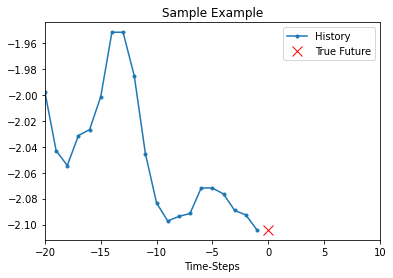

In [20]:
show_plot([x_train_uni[0], y_train_uni[0]], delta=0, title='Sample Example')

## Baseline

Before training a model, let's first build a baseline. Given an input point, the baseline method looks at all history and predicts the next point to be the average of the last 20 observations.

In [0]:
def baseline(history):
  return np.mean(history)

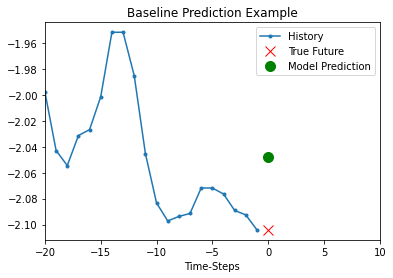

In [22]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 
          delta=0, 
          title='Baseline Prediction Example')

Next, let's try to train a recurrent neural model to beat the baseline.

## Recurrent Neural Network

A recurrent neural network is suitable for time series data. RNNs process a time series data step-by-step, maintaining state summarizing the state they've seen so far. Here you are going to use a gated RNN, LSTM (Long Short Term Memory), to build the model.

### Data Pipeline

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.cache().batch(BATCH_SIZE).repeat()

In [24]:
for data, label in train_univariate.take(1):
  print("Data shape (batch_size, time_series, features): {}".format(data.shape))
  print("Label shape: {}".format(label.shape))

Data shape (batch_size, time_series, features): (256, 20, 1)
Label shape: (256,)


![](https://www.tensorflow.org/tutorials/structured_data/images/time_series.png)

- Refer to Tensorflow.org (2020)

### Build the Model

In [0]:
def build_simple_lstm_model():
  def _body(inputs):
    x = tf.keras.layers.LSTM(units=8)(inputs)
    y = tf.keras.layers.Dense(1)(x)
    return y

  inputs = tf.keras.Input(shape=(x_train_uni.shape[-2:]))
  outputs = _body(inputs)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

simple_lstm_model = build_simple_lstm_model()

In [0]:
simple_lstm_model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.MeanAbsoluteError(),
  metrics=[
    tf.keras.metrics.MeanAbsoluteError()
  ]
)

Let's make a simple prediction.

In [27]:
for data, labels in val_univariate.take(1):
  print("Data shape: {}".format(data.shape))
  results = simple_lstm_model.predict(data)
  print("Results shape: {}".format(results.shape))

Data shape: (256, 20, 1)
Results shape: (256, 1)


### Train the Model

In [28]:
EPOCHS = 10
EVALUATION_INTERVAL = 200

simple_lstm_history = simple_lstm_model.fit(
  train_univariate, 
  epochs=EPOCHS, 
  steps_per_epoch=EVALUATION_INTERVAL,
  validation_data=val_univariate,
  validation_steps=50
)

Epoch 1/10
200/200 [==============================] - 1s 7ms/step - loss: 0.2453 - mean_absolute_error: 0.2453 - val_loss: 0.0650 - val_mean_absolute_error: 0.0650
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0786 - mean_absolute_error: 0.0786 - val_loss: 0.0295 - val_mean_absolute_error: 0.0295
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0396 - mean_absolute_error: 0.0396 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0204 - val_mean_absolute_error: 0.0204
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0240 - mean_absolute_error: 0.0240 - val_loss: 0.0196 - val_mean_absolute_error: 0.0196
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0266 - mean_absolute_error: 0.0266 - val_loss: 0.0195 - val_mean_absolute_error: 0.0195
Epoch 7/10
200/2

### Predict using the simple LSTM Model

Let's try to predict the data using the trained simple LSTM model.

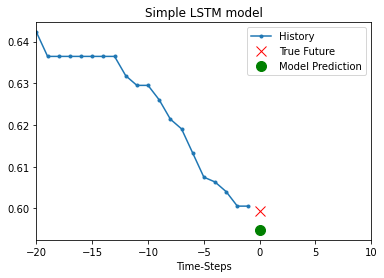

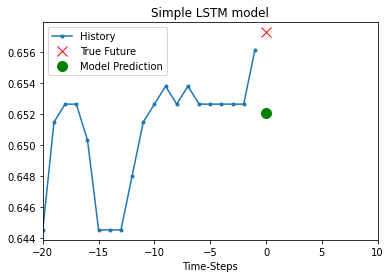

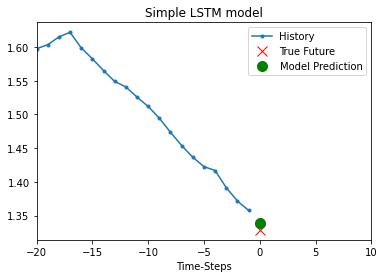

In [29]:
for data, label in val_univariate.take(3):
  # shape: (batch_size=256, 1)
  results = simple_lstm_model.predict(x=data)

  show_plot(plot_data=[data[0], label[0], results[0]], delta=0, title="Simple LSTM model")
  plt.show()

This univariate model looks better than the baseline. Next, we are going to work with a multivariate model.

# Forcast a multivariate time series

In a multivariate time series mode, you are going to use three features, temperature, atmospheric pressure, and air density, to train a model.

In [30]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [0]:
multi_features = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [32]:
features = df[multi_features]
features.index = df['Date Time']
features.head(n=5)

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

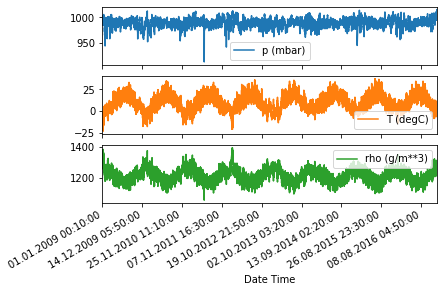

In [33]:
features.plot(subplots=True)
plt.show()

Before passing the values to the model, you have to normalize them first.

In [34]:
features.values.shape

(420551, 3)

In [35]:
dataset = features.values
dataset_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
dataset_std = dataset[:TRAIN_SPLIT].std(axis=0)

print("Mean {}, STD: {}".format(dataset_mean, dataset_std))

Mean [ 988.65117607    9.2332563  1216.40583777], STD: [ 8.23552219  8.6367204  40.86842488]


In [0]:
dataset = (dataset - dataset_mean) / dataset_std

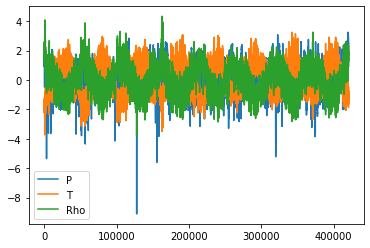

In [37]:
labels = ['P', 'T', 'Rho']
for axis in range(dataset.shape[1]):
  plt.plot(dataset[:, axis], label=labels[axis])
plt.legend()
plt.show()

In [40]:
dataset.shape

(420551, 3)

## Single step model

In a single time step model, the model learns to predict a single point in the future based on the history information.

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size, 
                      target_size, step, pred_single_step=False):
  """
  Args:
    dataset: the time series dataset for training
    target: the time series dataset for prediction
    start_index: the start index of the training dataset
    end_index: the end index of the training dataset
    history_size: the sampling size of the history information
    target_size: the target size of the prediction
    step: ths step to sample the history information, default is 1
    pred_single_step: whether to predict only one single step

  Returns:
    data: a numpy array of the training features
    labels: a numpy array of the target 
  """
  
  data = []
  labels = []

  # set the query indices
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  # prepare the datasets and the labels
  for idx in range(start_index, end_index):
    indics = range(idx - history_size, idx, step)
    data.append(dataset[indics])

    if pred_single_step:
      labels.append(target[idx + target_size])
    else:
      labels.append(target[idx:(idx + target_size)])
  
  return np.array(data), np.array(labels)

You are going to predict a single time step using the last of five-day observations (=6x24x5=720). However, the observations within an hour are not drastic changing. Here, we use only 120 observations to train a model to predict the next time step in the future. For the prediction, here the label for a datapoint is the temperature 12 hours (=6x12=72) in the future.

In [0]:
past_history_size = 720
future_target = 72
step = 6

x_train_single, y_train_single = multivariate_data(
  dataset=dataset, target=dataset[:, 1], start_index=0, end_index=TRAIN_SPLIT, 
  history_size=past_history_size, target_size=future_target, step=6, pred_single_step=True)

x_val_single, y_val_single = multivariate_data(
  dataset=dataset, target=dataset[:,1], start_index=TRAIN_SPLIT, end_index=None, 
  history_size=past_history_size, target_size=future_target, step=6, pred_single_step=True
)

Look at a single data point.

In [43]:
print("train shape: {}, target shape: {}".format(
  x_train_single[0].shape, y_train_single[0].shape))

train shape: (120, 3), target shape: ()


### Build Input Pipeline

In [0]:
train_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_single = train_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_single = val_single.batch(BATCH_SIZE).repeat()

### Build the Model

In [0]:
def build_multivar_single_step():
  def _body(inputs):
    x = tf.keras.layers.LSTM(units=32)(inputs)
    y = tf.keras.layers.Dense(units=1)(x)
    return y
  
  inputs = tf.keras.Input(shape=(x_train_single.shape[-2:]))
  outputs = _body(inputs)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

In [52]:
simple_step_model = build_multivar_single_step()
simple_step_model.compile(
  loss=tf.keras.losses.MeanAbsoluteError(),
  optimizer=tf.keras.optimizers.Adam(),
  metrics=[
    tf.keras.metrics.MeanAbsoluteError()
  ]
)

simple_step_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 120, 3)]          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                4608      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


### Train the Model

In [53]:
simple_step_history = simple_step_model.fit(
  train_single, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, 
  validation_data=val_single, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 2s 10ms/step - loss: 0.3735 - mean_absolute_error: 0.3735 - val_loss: 0.2675 - val_mean_absolute_error: 0.2675
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2698 - mean_absolute_error: 0.2698 - val_loss: 0.2515 - val_mean_absolute_error: 0.2515
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2687 - mean_absolute_error: 0.2687 - val_loss: 0.2581 - val_mean_absolute_error: 0.2581
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2640 - mean_absolute_error: 0.2640 - val_loss: 0.2370 - val_mean_absolute_error: 0.2370
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2315 - mean_absolute_error: 0.2315 - val_loss: 0.2350 - val_mean_absolute_error: 0.2350
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2437 - mean_absolute_error: 0.2441 - val_loss: 0.2534 - val_mean_absolute_error: 0.2534
Epoch 7/10
200/

In [55]:
simple_step_history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

In [0]:
def plot_single_history(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure()
  plt.plot(history.epoch, loss, 'b', label="training")
  plt.plot(history.epoch, val_loss, 'r', label='validation')
  plt.title("Loss Value")
  plt.legend(loc="upper right")
  plt.show()

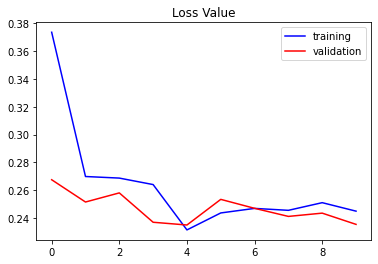

In [59]:
plot_single_history(simple_step_history)

### Predict the next time step

In [61]:
for x, y in val_single.take(3):
  print(x.shape, y.shape)

(256, 120, 3) (256,)
(256, 120, 3) (256,)
(256, 120, 3) (256,)


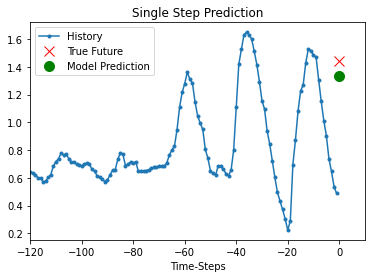

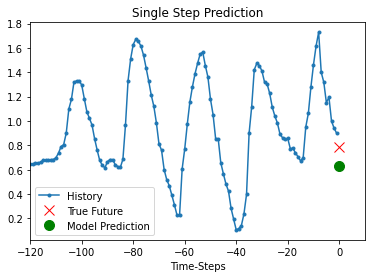

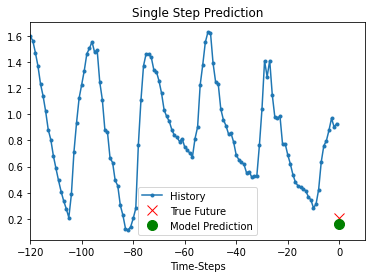

In [64]:
for x, y in val_single.take(3):
  results = simple_step_model.predict(x=x)

  show_plot([
    x[0][:, 1].numpy(), y[0].numpy(), results[0]
  ], delta=0, title="Single Step Prediction")

  plt.show()

## Multi-step Model

Let's move further to train a model to predict multiple data points in the future. In a multi-step model, given the size of the history information, it needs to predict a range of future values. Unlike the single-step model, the multi-step model needs to predict a sequence of the future.

In [0]:
past_history_size = 720
future_target = 72
STEP = 6

x_train_multi, y_train_multi = multivariate_data(
  dataset=dataset, target=dataset[:,1], start_index=0, end_index=TRAIN_SPLIT, 
  history_size=past_history_size, target_size=future_target, step=STEP, pred_single_step=False)
x_val_multi, y_val_multi = multivariate_data(
  dataset=dataset, target=dataset[:,1], start_index=TRAIN_SPLIT, end_index=None, 
  history_size=past_history_size, target_size=future_target, step=STEP, pred_single_step=False)

In [66]:
print("Train features shape: {}, target sequence shape: {}".format(
  x_train_multi[0].shape, y_train_multi[0].shape
))

Train features shape: (120, 3), target sequence shape: (72,)


### Build Input Pipeline

In [0]:
train_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_multi = train_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_multi = val_multi.cache().batch(BATCH_SIZE).repeat()

Plot a sample data-point.

In [69]:
for data, labels in train_multi.take(1):
  print("Data shape: {}, label shape: {}".format(
    data.shape, labels.shape
  ))

Data shape: (256, 120, 3), label shape: (256, 72)


In [0]:
def multi_step_plot(history, true_future, predictions):
  plt.figure(figsize=(12, 6))
  num_times = create_time_steps(length=len(history))
  num_truth = len(true_future)

  plt.plot(num_times, np.array(history[:,1]), label="history")
  # np.arange(num_truth) / STEP: back to hour scale
  plt.plot(np.arange(num_truth) / STEP, np.array(true_future), 'bo', label='true future')

  if predictions.any():
    plt.plot(np.arange(num_truth) / STEP, np.array(predictions), 'ro', label='prediction')

  plt.legend(loc="upper left")
  plt.show()

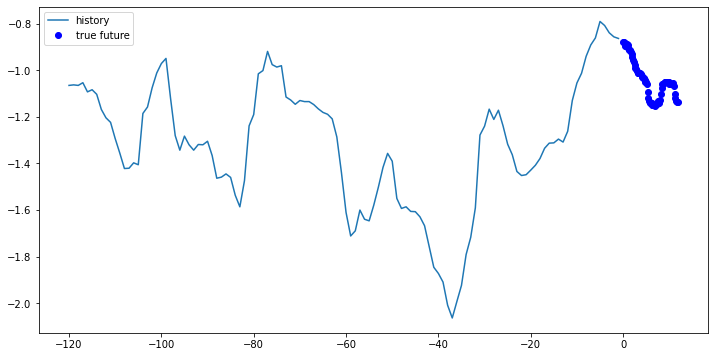

In [71]:
for x, y in train_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

### Build the Model

While building the model, you can different thoughts about making predictions. You can predict one step by step. Use the newly predicted step as the last history, pass this new sequence as the input to predict the next one step value. Another way is to predict the whole sequence. Here we conduct the second way. You are going to build a two-layer LSTM NN model.

In [72]:
def build_multi_model():
  def _body(inputs):
    # inputs: (batch_size, time_series_length=120, 3)

    # x becomes (batch_size, 120, 32)
    x = tf.keras.layers.LSTM(units=32, return_sequences=True)(inputs)

    # x becomes (batch_size, 16)
    x = tf.keras.layers.LSTM(units=16, activation='relu')(x)

    # y becomes (batch_size, future_target=72)
    y = tf.keras.layers.Dense(units=future_target)(x)
    return y

  inputs = tf.keras.Input(shape=(x_train_multi.shape[-2:]))
  outputs = _body(inputs)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

multi_model = build_multi_model()
multi_model.compile(
  loss=tf.keras.losses.MeanAbsoluteError(),
  optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0),
  metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

multi_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 120, 3)]          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 120, 32)           4608      
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_4 (Dense)              (None, 72)                1224      
Total params: 8,968
Trainable params: 8,968
Non-trainable params: 0
_________________________________________________________________


Let's try the prediction first.

In [73]:
for x, y in train_multi.take(1):
  results = multi_model.predict(x)
  print("Data shape: {}, label shape: {}, prediction shape: {}".format(
    x.shape, y.shape, results.shape
  ))

Data shape: (256, 120, 3), label shape: (256, 72), prediction shape: (256, 72)


### Train the Model

In [74]:
multi_step_history = multi_model.fit(
  train_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, 
  validation_data=val_multi, validation_steps=50
)

Epoch 1/10
200/200 [==============================] - 41s 204ms/step - loss: 0.7763 - mean_absolute_error: 0.7763 - val_loss: 0.3149 - val_mean_absolute_error: 0.3149
Epoch 2/10
200/200 [==============================] - 41s 204ms/step - loss: 0.3388 - mean_absolute_error: 0.3388 - val_loss: 0.2844 - val_mean_absolute_error: 0.2844
Epoch 3/10
200/200 [==============================] - 42s 208ms/step - loss: 0.3205 - mean_absolute_error: 0.3205 - val_loss: 0.2294 - val_mean_absolute_error: 0.2294
Epoch 4/10
200/200 [==============================] - 42s 212ms/step - loss: 0.2480 - mean_absolute_error: 0.2480 - val_loss: 0.2138 - val_mean_absolute_error: 0.2138
Epoch 5/10
200/200 [==============================] - 43s 214ms/step - loss: 0.2025 - mean_absolute_error: 0.2025 - val_loss: 0.2026 - val_mean_absolute_error: 0.2026
Epoch 6/10
200/200 [==============================] - 42s 208ms/step - loss: 0.2114 - mean_absolute_error: 0.2114 - val_loss: 0.2162 - val_mean_absolute_error: 0.216

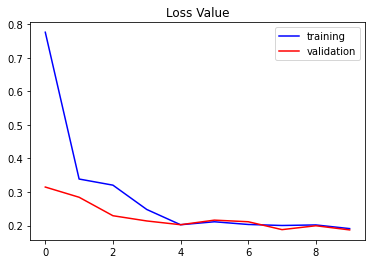

In [75]:
plot_single_history(multi_step_history)

### Predict the next time step

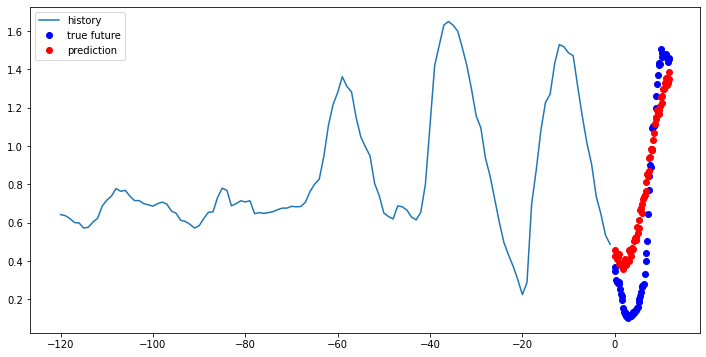

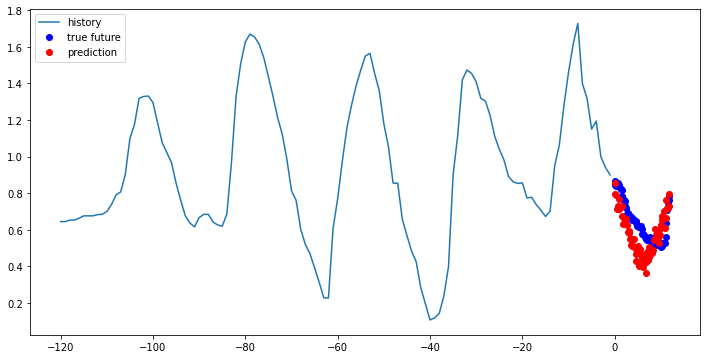

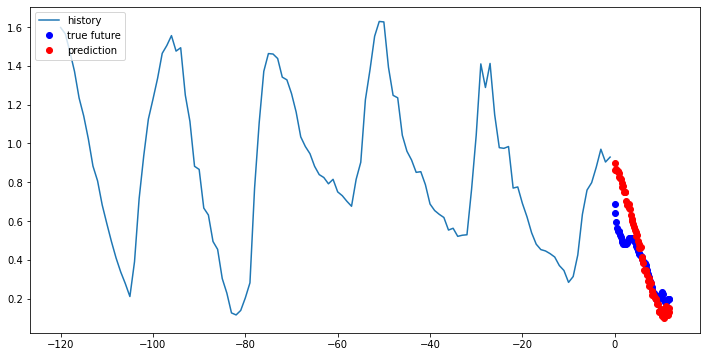

In [78]:
for x, y in val_multi.take(3):
  predictions = multi_model.predict(x)
  multi_step_plot(x[0], y[0], predictions[0])